In [141]:
#def main_function(test_year, starting_wallet_amount):

# The rest of your script can go here

In [142]:
!pip install pybaseball

In [143]:
!pip install --upgrade scikit-learn imbalanced-learn

In [144]:
!pip install featureranker

In [145]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import pybaseball as pyb
import pandas as pd
import time
import inspect
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
import json
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import optim
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import os
# from automatic_betting import Starting_Lineup
from featureranker.utils import view_data
from featureranker.rankers import classification_ranking
from featureranker.rankers import voting
# from featureranker import view_data
# from featureranker import classification_hyper_param_search
# from featureranker import classification_ranking
# from featureranker import voting
# from featureranker import plot_ranking
from bs4 import BeautifulSoup
import zipfile
import io
import os
import requests
import glob
import numpy as np
from tqdm.auto import tqdm
import pickle
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')
from torch.utils.data import TensorDataset

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import os

# Seed value
seed_value = 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `torch` pseudo-random generator at a fixed value
torch.manual_seed(seed_value)

# 5. Depending on whether you are using CUDA
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.

# 6. Configure a new global `torch` default floating point tensor type
# (optional, if you are using PyTorch)
torch.set_default_tensor_type('torch.FloatTensor')

# 7. For `torch.backends.cudnn`
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# import pycuda.autoinit
# import pycuda.gpuarray as gpuarray
pyb.cache.enable()
pyb.cache.config.cache_type='csv'
pyb.cache.config.save()
torch.cuda.empty_cache()

In [146]:
import os
import sys

# Check if the code is running in Google Colab
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    save_path='/content/drive/My Drive/baseball_pred/pybaseball_v3_saved'
    #Vegas Odds path
    vegas_betting_paths='/content/drive/My Drive/baseball_pred/betting_odds/'
    vegas_paths = [path for path in glob.glob(vegas_betting_paths + '*.xlsx')]

    #Scrambled Odds path
    scrambled_betting_paths='/content/drive/My Drive/baseball_pred/all_money_lines.csv'


    #Per_game_data path
    per_game_path='/content/drive/My Drive/baseball_pred/pybaseball/pybaseball/data/Lahman_MLB_per_game_data.csv'



    milb_batter_path = '/content/drive/My Drive/baseball_pred/SCRAPE_FANGRAPHS/APIBat/bat_standard.csv'
    milb_pitcher_path = '/content/drive/My Drive/baseball_pred/SCRAPE_FANGRAPHS/APIPit/pit_standard.csv'
    mlb_batter_path = '/content/drive/My Drive/baseball_pred/SCRAPE_FANGRAPHS/APIMlbbat/mlbbat_standard.csv'
    mlb_pitcher_path = '/content/drive/My Drive/baseball_pred/SCRAPE_FANGRAPHS/APIMlbpit/mlbpit_standard.csv'
    scoring_full_all_years='/content/drive/My Drive/baseball_pred/scoring_full_all_years.pkl'
    scoring_save_path='/content/drive/My Drive/baseball_pred/scoring_milb.pkl'
    def save_results_format(year):
      save_results=f'/content/drive/My Drive/baseball_pred/results/better_data_{year}.xlsx'
      return save_results
else:
    # Code to run if not in Google Colab
    # For example, set a local path for your files if on a local machine
    # local_drive_path = 'd:/Users/vile3/Google Drive'
    # if not os.path.exists(local_drive_path):
        # os.makedirs(local_drive_path)
        save_path='pybaseball_v3_saved'
        vegas_betting_paths='./betting_odds/'
        vegas_paths = [path for path in glob.glob(vegas_betting_paths + '*.xlsx')]

        #Scrambled Odds path
        scrambled_betting_paths='all_money_lines.csv'


        #Per_game_data path
        per_game_path='./pybaseball/pybaseball/data/Lahman_MLB_per_game_data.csv'



        milb_batter_path = './SCRAPE_FANGRAPHS/APIBat/bat_standard.csv'
        milb_pitcher_path = './SCRAPE_FANGRAPHS/APIPit/pit_standard.csv'
        mlb_batter_path = './SCRAPE_FANGRAPHS/APIMlbbat/mlbbat_standard.csv'
        mlb_pitcher_path = './SCRAPE_FANGRAPHS/APIMlbpit/mlbpit_standard.csv'
        scoring_full_all_years='scoring_full_all_years.pkl'
        scoring_save_path='scoring_milb.pkl'
        def save_results_format(year):
          save_results=f'./results/better_data_{year}.xlsx'
          return save_results
    # Now you can use local_drive_path as the base path for your file operations


# Functions

In [147]:
# Check if CUDA is available

# Move your model to the GPU
# model = model.to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# When you load your data, move it to the GPU
# Assume inputs and labels are your input data and labels
# inputs, labels = inputs.to(device), labels.to(device)


# Neural Network

In [148]:
class vector_dataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        vec = torch.tensor(self.X[idx], dtype=torch.float)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return vec, label


class neural_net(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_num, output_size, dropout_rate):
        super(neural_net, self).__init__()
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_num = hidden_num
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_num):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.gelu(self.input_layer(x))
        x = self.dropout(x)
        for i in range(self.hidden_num):
            x = self.gelu(self.hidden_layers[i](x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x


#CHECK TO SEE HOW GOOD MODEL IS
def cross_validate(model, X, y, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    for train_indices, valid_indices in kfold.split(X):
        # Split the data using .iloc for position-based indexing
        X_train, X_valid = X.iloc[train_indices], X.iloc[valid_indices]
        y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices]

        # Convert to PyTorch datasets
        train_dataset = vector_dataset(X_train, y_train)
        valid_dataset = vector_dataset(X_valid, y_valid)

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters())

        # Train the model on the training data
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate the model on the validation data
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        scores.append(accuracy)

    return scores


import os
import datetime
import torch
from tqdm import tqdm


def train_and_evaluate_model(model, train_loader, val_loader, test_loader, optimizer, criterion, scheduler, date, patience=5, num_epochs=50):
    best_loss = float('inf')
    patience_counter = 0
    
    # Create a directory based on the current date to save the models
    model_save_dir = f'models/{date}'
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    
    # Update the path for saving the best model to include the date-named folder
    best_model_path = os.path.join(model_save_dir, 'best_model.pth')
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        print(f'Training Loss: {avg_train_loss}')

        model.eval()
        valid_losses = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.squeeze())
                valid_losses.append(loss.item())

        avg_valid_loss = np.mean(valid_losses)
        print(f'Validation Loss: {avg_valid_loss}')
    
        scheduler.step(avg_valid_loss)
        
        # Save the model for the current epoch in the date-named folder
        epoch_model_path = os.path.join(model_save_dir, f'model_epoch_{epoch + 1}.pth')
        torch.save(model.state_dict(), epoch_model_path)

        # Update the best model if validation loss improves
        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping triggered')
                break

    # Load the best model
    # model.load_state_dict(torch.load(best_model_path))
    model.load_state_dict(torch.load(best_model_path, map_location=device))

    # Evaluate the best model
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:  # Use test data for final evaluation
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device

            # label5=(inputs.device)
            # label6=(labels.device)
            # model3=(next(model.parameters()).device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate confusion matrix and classification report
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds,output_dict=True)
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(class_report)
    return conf_matrix, class_report

import os


def save_to_path(df, filename, folder=save_path):
    if not os.path.exists(folder):
        os.makedirs(folder)

    path = os.path.join(folder, f'{filename}.csv')

    if os.path.exists(path):
        print(f'File {path} already exists.')
    else:
        df.to_csv(path, index=True)
        print(f'{filename} saved to {path}')


def process_per_game_data(per_game_data, columns_to_keep, train_years, betting_date):
    # Create 'DateHmTmVisTm' column
    per_game_data['Game_Number'] = per_game_data.groupby(['Date', 'HmTm', 'VisTm']).cumcount() + 1
    per_game_data['Game_ID'] = (
        per_game_data['Date'].astype(str) +
        per_game_data['HmTm'] +
        per_game_data['VisTm'] +
        per_game_data['Game_Number'].astype(str)
    )
    # Reset the current index
    per_game_data = per_game_data.reset_index()
    # Set the new index
    per_game_data.set_index('Game_ID', inplace=True)
    # Drop unnecessary columns
    per_game_data = per_game_data[columns_to_keep]
    # Create 'winner' column
    per_game_data['winner'] = np.where(per_game_data['HmRuns'] > per_game_data['VisRuns'], 1, 0)

    # Truncate rows based on the lowest train year
    lowest_train_year = min(train_years)
    per_game_data = per_game_data[per_game_data.index.str[:4] >= str(lowest_train_year)]
    
    # Convert betting_date from 'yyyy-mm-dd' to 'yyyymmdd' to match the index format
    betting_date_formatted = betting_date.replace('-', '')
    betting_date_formatted = str(int(betting_date_formatted)-1)
    # Truncate rows based on the betting date using the formatted index
    # Since the index is 'yyyymmddhometeamvisteam', we only compare the 'yyyymmdd' part
    per_game_data = per_game_data[per_game_data.index.str[:8] <= betting_date_formatted]
    
    return per_game_data


def process_vegas_odds(paths):

    xlsx_dataframes = []
    for i, path in enumerate(paths):
        temp_df = pd.read_excel(path, skiprows=0 if i > 0 else 0)
        temp_df.columns = temp_df.columns.str.replace('[^a-zA-Z0-9]', '')
        year = path[-9:-5]  # extract year from file name
        if 'Date' in temp_df.columns:
            temp_df['Date'] = year + temp_df['Date'].astype(str).str.zfill(4)  # format date as yyyymmdd
        xlsx_dataframes.append(temp_df)

    try:
        xlsx_dataframes = pd.concat(xlsx_dataframes, ignore_index=True)
    except pd.errors.InvalidIndexError:
        print('Error: Reindexing only valid with uniquely valued Index objects')

    xlsx_dataframes = xlsx_dataframes[['Date', 'VH', 'Team', 'Open']]
    home_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'H'].copy()
    visiting_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'V'].copy()

    home_teams_df.rename(columns={'Date': 'date', 'Team': 'home_team', 'Open': 'home_open'}, inplace=True)
    visiting_teams_df.rename(columns={'Date': 'date', 'Team': 'visiting_team', 'Open': 'visiting_open'}, inplace=True)

    # Merge on 'date'
    xlsx_dataframes = pd.concat([home_teams_df.reset_index(drop=True), visiting_teams_df.reset_index(drop=True)], axis=1)
    xlsx_dataframes = xlsx_dataframes.loc[:,~xlsx_dataframes.columns.duplicated()]
    xlsx_dataframes = xlsx_dataframes[['date', 'home_team', 'visiting_team','home_open','visiting_open']]
    xlsx_dataframes['Game_Number'] = xlsx_dataframes.groupby(['date', 'home_team', 'visiting_team']).cumcount() + 1
    xlsx_dataframes['Game_ID'] = (
        xlsx_dataframes['date'].astype(str) +
        xlsx_dataframes['home_team'] +
        xlsx_dataframes['visiting_team'] +
        xlsx_dataframes['Game_Number'].astype(str)
    )

    xlsx_dataframes.set_index('Game_ID', inplace=True)

    xlsx_dataframes.drop(['Game_Number','date','home_team','visiting_team'], axis=1, inplace=True)
    print(xlsx_dataframes)

    return xlsx_dataframes


import time
from requests.exceptions import RequestException


def fetch_data_with_retry(fetch_func, data_type, max_retries=5, retry_delay=3):
    retries = 0
    while retries < max_retries:
        try:
            data = fetch_func(True)
            print(f"{data_type} data fetched successfully.")
            return data
        except RequestException as e:
            retries += 1
            print(f"Attempt {retries} failed with error: {e}. Retrying after {retry_delay} seconds...")
            time.sleep(retry_delay)
            retry_delay *= 2  # Exponential backoff
    print(f"Failed to fetch {data_type} data after {max_retries} attempts.")
    return None


def process_scrambled_odds(df):
    df['Game_Number'] = df.groupby(['date', 'home_team', 'visiting_team']).cumcount() + 1
    df['Game_ID'] = (
        df['date'].astype(str) +
        df['home_team'] +
        df['visiting_team'] +
        df['Game_Number'].astype(str)
    )

    df.set_index('Game_ID', inplace=True)

    # Fix: Correct the drop method usage by specifying the column indices correctly
    columns_to_drop = df.columns[[0, 1]]
    print("Dropping columns:", columns_to_drop)
    df = df.drop(columns=columns_to_drop)
    return df


def remove_columns_with_nan(df, NaN_cutoff_percentage):
    NaN_cutoff = NaN_cutoff_percentage / 100.0
    return df.loc[:, df.isnull().mean() < NaN_cutoff]


def weighted_average(group, weights):
    return pd.Series(
        {col: np.average(group[col], weights=weights.loc[group.index]) for col in group.columns}
    )


def merge_player_stats(per_game_data, column, player_data_dict):
    """
    Merges player statistics into the main DataFrame based on player ID.
    """
    stats_df = pd.DataFrame.from_dict(player_data_dict, orient='index').reset_index().rename(columns={'index': column})
    merged_data = per_game_data.merge(stats_df, on=column, how='left', suffixes=('', f'_{column}_stats'))
    return merged_data


def identify_missing_player_ids(per_game_data, column):
    """
    Identifies missing player IDs and the games they're missing from.
    """
    missing_player_ids = {}
    missing_ids_mask = per_game_data.loc[:, per_game_data.columns.str.contains(f'_{column}_stats')].isna().any(axis=1)
    missing_ids = per_game_data.loc[missing_ids_mask, column].dropna().unique()
    
    for missing_id in missing_ids:
        if missing_id not in missing_player_ids:
            missing_player_ids[missing_id] = []
        missing_player_ids[missing_id].extend(
            per_game_data[per_game_data[column] == missing_id]['Game_ID'].tolist()
        )
    
    # Remove duplicates and sort
    for player_id, game_ids in missing_player_ids.items():
        missing_player_ids[player_id] = sorted(set(game_ids))
    
    return missing_player_ids


def replace_ids_with_stats_and_catalog_missing(per_game_data, player_id_columns, player_data_dicts):
    """
    Replaces player IDs with their stats and catalogs any missing player IDs.
    """
    per_game_data = per_game_data.reset_index().rename(columns={'index': 'Game_ID'})
    missing_player_ids = {}

    for column in player_id_columns:
        player_type = 'pitcher' if 'PchID' in column else 'batter'
        per_game_data = merge_player_stats(per_game_data, column, player_data_dicts[player_type])
        column_missing_ids = identify_missing_player_ids(per_game_data, column)
        
        # Update missing_player_ids dictionary
        for key, value in column_missing_ids.items():
            if key not in missing_player_ids:
                missing_player_ids[key] = value
            else:
                missing_player_ids[key].extend(value)
                missing_player_ids[key] = sorted(set(missing_player_ids[key]))  # Remove duplicates and sort
        
        per_game_data.drop(column, axis=1, inplace=True)

    per_game_data = per_game_data.set_index('Game_ID')
    return per_game_data, missing_player_ids


def label_encode(df):
    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col])
    return df


def remove_excess_player_columns(player_data,columns_to_remove):
    player_data = player_data.drop(columns=columns_to_remove)
    return player_data


def split_dataframe_data(per_game_data_reduced, train_years, validation_year, test_year):
    # Create a mask for the training set
    train_years = [str(year) for year in train_years]
    validation_year = str(validation_year)
    test_year = str(test_year)
    train_mask = per_game_data_reduced.index.str.contains('|'.join(train_years))

    # Split the data into training and validation sets
    X_train = per_game_data_reduced[train_mask].drop(['winner', 'home_odds', 'visiting_odds', 'HmRuns', 'VisRuns'], axis=1)
    y_train = per_game_data_reduced.loc[train_mask, 'winner']

    # Create a mask for the validation set
    validation_mask = per_game_data_reduced.index.str.contains(validation_year)
    X_validation = per_game_data_reduced[validation_mask].drop(['winner', 'home_odds', 'visiting_odds', 'HmRuns', 'VisRuns'], axis=1)
    y_validation = per_game_data_reduced.loc[validation_mask, 'winner']

    # Create a mask for the test set
    test_mask = per_game_data_reduced.index.str.contains(test_year)
    X_test = per_game_data_reduced[test_mask].drop(['winner', 'home_odds', 'visiting_odds', 'HmRuns', 'VisRuns'], axis=1)
    y_test = per_game_data_reduced.loc[test_mask, 'winner']

    return X_train, y_train, X_validation, y_validation, X_test, y_test


def split_data_by_year(df, train_years, validation_year, test_year):
    # Convert train_years and test_year to integers for the comparison
    train_years_int = [int(year) for year in train_years]
    test_year_int = int(test_year)

    # Extract the year from the 'Game_ID' column
    df['year'] = df.index.str[:4].astype(int)

    # Create masks for splitting the data based on 'year'
    train_mask = df['year'].isin(train_years_int)
    val_mask = df['year'] == validation_year
    test_mask = df['year'] == test_year_int

    # Split the data
    train_data = df[train_mask]
    val_data = df[val_mask]
    test_data = df[test_mask]

    # Drop the 'year' column as it's no longer needed
    df.drop('year', axis=1, inplace=True)

    return train_data, val_data, test_data


def split_data(X, y, years):
    # Check if 'years' is a list, if not, make it a list
    if not isinstance(years, list):
        years = [years]

    # Convert all elements in 'years' to strings
    years = [str(year) for year in years]

    # Create a mask for the specified years
    year_mask = X.index.str.contains('|'.join(years))

    # Split the data for the specified years
    X_years = X[year_mask]
    y_years = y[year_mask]

    return X_years, y_years


def predict_game_outcome(game_ids, game_data, model, augment=False, base_bet=100, scaler=1):
    num_games = len(game_ids)
    results, bets, probss, skipped = [None]*num_games, [None]*num_games, [None]*num_games, [None]*num_games

  
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model.eval()
    # model.to(device)  # Move your model to the GPU
    for i in range(num_games):
        try:
            game_vector = torch.tensor([game_data[i]], dtype=torch.float).to(device)
            # game_vector = torch.tensor([game_data[i]], dtype=torch.float)

            with torch.no_grad():
                logits = model(game_vector)
                probs = logits.softmax(dim=-1)
                _, pred = torch.max(logits, 1)
                pred = pred.item()
                prob = probs[0][pred].item()
            results[i] = (game_ids[i], 'True' if pred else 'False')
            bets[i] = base_bet * prob * scaler if augment else base_bet
            probss[i] = prob
        except:
            skipped.append(i)
    return results, bets, skipped, probss


def Impute(df, method):
    # Create an imputer instance
    imputer = SimpleImputer(strategy=method)
    # Fit and transform the DataFrame, but keep the index
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)
    return df_imputed


class Better:
    def __init__(self, initial_wallet=1000):
        self.wallet = initial_wallet
        self.wallet_history = [initial_wallet]  # Store the initial wallet balance
        self.bet_history = []
        self.detailed_bet_history = []  # Store detailed information about each bet

    def bet(self, game_indices, bet_on_home_team, amount_bet, game_data, prob, augment=False, scaler=1):
        # Ensure the bettor has enough money in the wallet
        amount_bet = max(self.wallet * 0.01, 10)
        amount_bet = amount_bet * prob * scaler if augment else amount_bet
        if amount_bet > self.wallet:
            print("Insufficient funds for this bet.")
            return

        # Retrieve the game data
        games = game_data.loc[game_indices]

        # If games is a DataFrame, iterate over its rows
        if isinstance(games, pd.DataFrame):
            game_iter = games.iterrows()
        else:  # If games is a Series (single row), create a one-item iterator
            game_iter = [(game_indices, games)]

        for index, game in game_iter:
            # Retrieve the odds
            home_odds = game['home_odds']
            away_odds = game['visiting_odds']

            # Determine the odds based on the team bet on
            odds = home_odds if bet_on_home_team else away_odds

            # Determine if the bet was a win or loss
            bet_won = (game['winner'] == bet_on_home_team)

            # Calculate the amount gained or lost
            if bet_won:
                if odds > 0:
                    gain = amount_bet * odds / 100
                else:
                    gain = amount_bet / (odds / -100)
                self.wallet += gain
                outcome = 'win'
            else:
                self.wallet -= amount_bet
                outcome = 'loss'

            # Store the new wallet balance and detailed bet history
            self.wallet_history.append(self.wallet)
            self.bet_history.append(amount_bet)
            self.detailed_bet_history.append({
                'game_index': index,
                'bet_on_home_team': bet_on_home_team,
                'amount_bet': amount_bet,
                'outcome': outcome,
                'wallet_after_bet': self.wallet
            })

        return self.wallet, self.detailed_bet_history  # Optionally return the wallet and detailed bet history


def combine_odds(per_game_data, vegas_odds, scrambled_odds):
    # Merge vegas_odds and scrambled_odds into per_game_data
    per_game_data = per_game_data.merge(vegas_odds, how='left', left_index=True, right_index=True)
    per_game_data = per_game_data.merge(scrambled_odds, how='left', left_index=True, right_index=True, suffixes=('_vegas', '_scrambled'))

    # Create new columns 'home_odds' and 'visiting_odds' where vegas_odds takes precedence
    per_game_data['home_odds'] = per_game_data['home_open_vegas'].combine_first(per_game_data['home_open_scrambled'])
    per_game_data['visiting_odds'] = per_game_data['visiting_open_vegas'].combine_first(per_game_data['visiting_open_scrambled'])

    # Fill any remaining NaNs with -110
    per_game_data['home_odds'].fillna(-110, inplace=True)
    per_game_data['visiting_odds'].fillna(-110, inplace=True)

    # Drop the original odds columns
    per_game_data.drop(columns=['home_open_vegas', 'visiting_open_vegas', 'home_open_scrambled', 'visiting_open_scrambled'], inplace=True)

    # Reset the index before returning


    # return per_game_data[['home_odds', 'visiting_odds']]
    return per_game_data


from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import copy

from sklearn.metrics import accuracy_score


def permutation_importance(model, loader, criterion, metric):
    model.eval()
    original_score = metric(model, loader, criterion)
    importances = []
    for i in range(loader.dataset.X.size(1)):  # Assuming 'X' is the attribute storing your input data
        temp = loader.dataset.X.clone()
        temp[:, i] = torch.randperm(temp.size(0))
        temp_dataset = vector_dataset(temp, loader.dataset.y)  # Assuming 'y' is the attribute storing your labels
        temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False)
        score = metric(model, temp_loader, criterion)
        importances.append(original_score - score)
    return importances


def automated_feature_selection(model, train_loader, val_loader, test_loader, optimizer, criterion, metric, patience=5, num_epochs=50):
    best_score = 0
    best_model = None
    important_features = list(range(len(train_loader.dataset[0][0])))
    while len(important_features) > 0:
        # Train the model
        conf_matrix, class_report = train_and_evaluate_model(model, train_loader, val_loader, test_loader, optimizer, criterion, patience, num_epochs)
        # Calculate the score
        score = class_report['accuracy']  # Assuming class_report is a dictionary with 'accuracy' key
        # If the score has improved, update the best score and best model
        if score > best_score:
            best_score = score
            best_model = copy.deepcopy(model)
        else:
            # If the score has not improved, add the last removed feature back and break the loop
            important_features.append(last_removed_feature)
            break
        # Calculate the permutation importance
        importances = permutation_importance(model, val_loader.dataset.tensors[0][:, important_features], val_loader.dataset.tensors[1], metric)
        # Remove the least important feature
        last_removed_feature = important_features.pop(np.argmin(importances))
    return best_model, important_features
# usage


from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, MaxAbsScaler, PowerTransformer, QuantileTransformer
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, MaxAbsScaler, PowerTransformer, QuantileTransformer


def scale_data(X, method='minmax'):
    """
    Scales the data using various scaling methods.

    Parameters:
    - X: Data as a pandas DataFrame.
    - method: The scaling method to use ('minmax', 'standard', 'robust', 'normalizer', 'maxabs', 'power', 'quantile').

    Returns:
    - X_scaled: Scaled data as a pandas DataFrame.
    """
    scalers = {
        'minmax': MinMaxScaler(),
        'standard': StandardScaler(),
        'robust': RobustScaler(),
        'normalizer': Normalizer(),
        'maxabs': MaxAbsScaler(),
        'power': PowerTransformer(),
        'quantile': QuantileTransformer(output_distribution='normal')
    }

    if method not in scalers:
        raise ValueError(f"Method should be one of {list(scalers.keys())}")

    scaler = scalers[method]

    # Fit and transform the data.
    X_scaled = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)

    return X_scaled

    from sklearn.impute import SimpleImputer


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder


def process_data(df, labels, thresh=0.8, columns_to_drop=None):
    # Ensure labels is a string and not a column itself
    if not isinstance(labels, str):
        raise ValueError("labels parameter should be a string representing the column name of the target variable")

    # Separate the target variable
    y = df[labels].copy()
    df_clean = df.drop(columns=columns_to_drop + [labels] if columns_to_drop is not None else [labels])

    # Impute missing values for numerical columns
    num_columns = df_clean.select_dtypes(include=['int64', 'float64']).columns
    num_imputer = SimpleImputer(strategy='mean')
    df_clean[num_columns] = num_imputer.fit_transform(df_clean[num_columns])

    # Impute missing values for categorical columns
    cat_columns = df_clean.select_dtypes(include=['object', 'string', 'bool']).columns
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df_clean[cat_columns] = cat_imputer.fit_transform(df_clean[cat_columns])

    # Apply threshold for dropping columns with too many NAs
    threshold = thresh * len(df)
    df_clean = df_clean.dropna(axis=1, thresh=threshold)

    # Label encoding for categorical columns
    le = LabelEncoder()
    for column in cat_columns:
        # Ensure no NaN values are present before label encoding
        df_clean[column] = le.fit_transform(df_clean[column])

    # Concatenate the cleaned df_clean with the target y
    combined = pd.concat([df_clean, y], axis=1)

    # Drop rows with any remaining NaN values
    combined_clean = combined.dropna()

    # Separate the features and target again
    df_clean = combined_clean.drop(columns=[labels])
    y = combined_clean[labels]

    # Convert boolean to int if necessary
    if y.dtype == 'boolean':
        y = y.astype(int)

    return df_clean, y


def aggregate_player_data(data, playerid):
    # Set the playerid as the index if it's not already
    # if isinstance(years, int):
    #     years = [years]
    # else:
    #     years = list(map(int, years))
    # data = data[data['year_ID'].isin(years)]
    numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = data.select_dtypes(exclude=['int64', 'float64']).columns

    # Impute numerical columns with mean
    data[numerical_cols] = Impute(data[numerical_cols], 'mean')

    # Impute categorical columns with the most frequent value
    data[categorical_cols] = Impute(data[categorical_cols], 'most_frequent')

    # Group by playerid and aggregate: mean for numerical columns, most frequent for categorical columns
    data_aggregated = data.groupby(playerid).agg({**{col: 'mean' for col in numerical_cols}, 
                                                 **{col: lambda x: x.mode()[0] if not x.empty else None for col in categorical_cols}})

    # Apply label encoding to categorical columns
    data_aggregated = label_encode_columns(data_aggregated, categorical_cols)
 
    return data_aggregated

# Assuming batter_data and pitcher_data are pandas DataFrames and playerid is the column with player IDs
# If you need to label encode the categorical columns after aggregation
from sklearn.preprocessing import LabelEncoder

# Function to label encode categorical columns
def label_encode_columns(df, categorical_columns):
    le = LabelEncoder()
    for col in categorical_columns:
        # Fill NaN with a placeholder string and encode
        df[col] = le.fit_transform(df[col].astype(str))
    return df


def prepare_data(batter_data, pitcher_data, per_game_data, playerid, years):
    # Aggregate the player data for the specified years
    batter_aggregated = aggregate_player_data(batter_data, playerid, years)
    pitcher_aggregated = aggregate_player_data(pitcher_data, playerid, years)

    # Check if the index has a 0 value and if so, remove the corresponding row
    if 0 in batter_aggregated.index:
        batter_aggregated.drop(index=0, inplace=True)
    if 0 in pitcher_aggregated.index:
        pitcher_aggregated.drop(index=0, inplace=True)


    pitcher_columns = ['HmStPchID', 'VisStPchID']
    batter_columns = ['HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID']

    # Create separate dictionaries for the data
    player_data_dictionary = {
        'pitcher': pitcher_aggregated.to_dict('index'),
        'batter': batter_aggregated.to_dict('index')
    }

    # Call the function with the player ID columns
    player_id_columns = pitcher_columns + batter_columns

    # Replace player IDs with stats and catalog missing IDs
    per_game_finished, missing_player_ids = replace_ids_with_stats_and_catalog_missing(per_game_data, player_id_columns, player_data_dictionary)

    return per_game_finished, missing_player_ids


def list_old_bwar_data():
    # The URL of the page where the zip files are listed
    url = 'https://www.baseball-reference.com/data/'

    # Send a GET request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the HTML content of the page
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Find all the <a> tags in the HTML
        a_tags = soup.find_all('a')
        
        # Filter out the <a> tags that link to .zip files and prepend the base URL to form a complete URL
        zip_links = [url + a['href'] for a in a_tags if a['href'].endswith('.zip')]
        
        # Print out the list of zip file links
        # for link in zip_links:
            # print(link)
    else:
        print(f"Failed to fetch the webpage. Status code: {response.status_code}")
    return zip_links


from datetime import datetime


def find_most_recent_zip(zip_links, input_date):
    from datetime import datetime  # Ensure datetime is imported

    # Convert input_date string to a datetime object
    input_date = datetime.strptime(input_date, '%Y-%m-%d')
    
    # Initialize variable to keep track of the most recent date before input_date
    most_recent_date = None
    most_recent_link = None
    
    # Iterate over the list of zip links
    for link in zip_links:
        # Extract the date from the link (assuming the date is in the format YYYY-MM-DD)
        parts = link.split('/')[-1].split('-')
        link_date_str = '-'.join(parts[1:4]).replace('.zip', '')
        try:
            # Convert the extracted date string to a datetime object
            link_date = datetime.strptime(link_date_str, '%Y-%m-%d')
            
            # Check if this date is more recent than the current most_recent_date and before the input_date
            if (most_recent_date is None or link_date > most_recent_date) and link_date < input_date:
                most_recent_date = link_date
                most_recent_link = link
        except ValueError:
            # If there is a ValueError, it means the conversion to a datetime object failed, likely due to incorrect format
            continue  # Skip this link if the date cannot be parsed
    
    # Return the most recent link
    return most_recent_link


def scrape_old_bwar_data(most_recent_link):
    # URL of the zip file
    zip_file_url = most_recent_link

    # The path to the folder where you want to save the extracted files
    # Make sure this folder exists or create it with os.makedirs()
    download_folder = os.path.join(os.getcwd(), 'old_bwar_data')
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)

    # Send a GET request to the URL
    response = requests.get(zip_file_url)

    # Initialize a list to hold the content of each text file
    text_files_content = []

    # Check if the request was successful
    if response.status_code == 200:
        # Use BytesIO to read the downloaded zip file
        zip_file_bytes = io.BytesIO(response.content)

        # Open the zip file
        with zipfile.ZipFile(zip_file_bytes, 'r') as zip_ref:
            # Extract all the contents into the specified directory
            zip_ref.extractall(download_folder)
            # List all the file names in the zip file
            for file_name in zip_ref.namelist():
                # Check if the file is a text file
                if file_name.endswith('.txt'):
                    # Read the text file
                    with zip_ref.open(file_name) as text_file:
                        text_content = text_file.read()
                        # Add the text content to the list
                        text_files_content.append(text_content.decode('utf-8'))
    else:
        print(f"Failed to download the zip file. Status code: {response.status_code}")

    # Return the list of text file contents
    return text_files_content


def Starting_Lineup(date):


    """# Functions

    # Importing Data

    # Formatting player data

    # Formatting per game data
    """

    # from bs4 import BeautifulSoup
    import re
    # import pybaseball as pyb
    # Fetch the HTML content from the webpage
    url = f'https://www.mlb.com/starting-lineups/{date}'
    response = requests.get(url)
    html_content = response.text


    # Assuming `html_content` contains the HTML source you provided
    soup = BeautifulSoup(html_content, 'html.parser')

    # Regular expression to extract numeric ID from player URL
    player_id_pattern = re.compile(r'/player/.*-(\d+)$')

    # Collect all MLBAM IDs
    all_mlbam_ids = set()

    # Find all game containers
    games = soup.find_all('div', class_='starting-lineups__matchup')

    # Check if there are no games found for the given date



    for game in games:
        # Extract pitcher and batter IDs
        pitchers = game.find_all('a', class_='starting-lineups__pitcher--link')
        batters = game.find_all('a', class_='starting-lineups__player--link')
        player_links = pitchers + batters

        for player_link in player_links:
            player_id_match = re.search(player_id_pattern, player_link['href'])
            if player_id_match:
                all_mlbam_ids.add(int(player_id_match.group(1)))

    # Perform reverse lookup to get Retro IDs
    all_player_info = pyb.playerid_reverse_lookup(list(all_mlbam_ids), key_type='mlbam')
    mlbam_to_retro = all_player_info.set_index('key_mlbam')['key_retro'].to_dict()


    game_matchups = {}


    # Use enumerate to get both the index and the game object for uniqueness
    try:
        for index, game in enumerate(games):
            teams = game.find_all('span', class_='starting-lineups__team-name')
            away_team_code = teams[0].find('a')['data-tri-code']
            home_team_code = teams[2].find('a')['data-tri-code']
            pitchers = game.find_all('a', class_='starting-lineups__pitcher--link')
            if len(pitchers) < 3:  # Ensure there are at least 3 links, indicating both away and home pitchers are present
                continue  # Skip this game if there aren't enough pitcher links
            away_pitcher_id = re.search(player_id_pattern, pitchers[0]['href']).group(1) if len(pitchers) > 0 else None
            home_pitcher_id = re.search(player_id_pattern, pitchers[2]['href']).group(1) if len(pitchers) > 1 else None
            if not away_pitcher_id or not home_pitcher_id:
                continue
            # Extract batters IDs for both teams
            away_batters = game.find('ol', class_='starting-lineups__team--away').find_all('a', class_='starting-lineups__player--link')
            home_batters = game.find('ol', class_='starting-lineups__team--home').find_all('a', class_='starting-lineups__player--link')

            away_batters_ids = [re.search(player_id_pattern, batter['href']).group(1) for batter in away_batters]
            home_batters_ids = [re.search(player_id_pattern, batter['href']).group(1) for batter in home_batters]
            if not away_batters_ids or not home_batters_ids:
                continue
            # Populate the game_matchups dictionary with a unique game key
            game_key = f"{away_team_code}@{home_team_code}_{index}"
            game_matchups[game_key] = {
                'away_team': away_team_code,
                'home_team': home_team_code,
                'away_pitcher': {'mlbam_id': away_pitcher_id, 'retro_id': mlbam_to_retro.get(int(away_pitcher_id)) if away_pitcher_id else None},
                'home_pitcher': {'mlbam_id': home_pitcher_id, 'retro_id': mlbam_to_retro.get(int(home_pitcher_id)) if home_pitcher_id else None},
                'away_players': [{'mlbam_id': id, 'retro_id': mlbam_to_retro.get(int(id))} for id in away_batters_ids],
                'home_players': [{'mlbam_id': id, 'retro_id': mlbam_to_retro.get(int(id))} for id in home_batters_ids]
            }
    except IndexError:
        print(f"No games found or incomplete data for {date}.")
        return None 
            # Extract pitcher IDs


    # print(game_matchups)

    """# Set-up Neural Network

    # Predict the outcome of the season and calculate profit
    """

    # Define a mapping of incorrect team abbreviations to correct ones
    team_nomenclature_mapping = {
        'CHC': 'CHN',  # Chicago Cubs
        'WSH': 'WAS',  # Washington Nationals
        'NYM': 'NYN',  # New York Mets
        'BOS': 'BOS',  # Boston Red Sox
        'ATL': 'ATL',  # Atlanta Braves
        'TEX': 'TEX',  # Texas Rangers
        'HOU': 'HOU',  # Houston Astros
        'KC ': 'KCA',   # Kansas City Royals
        'LAA': 'ANA',  # Los Angeles Angels
        'MIN': 'MIN',  # Minnesota Twins
        'MIL': 'MIL',  # Milwaukee Brewers
        'AZ ': 'ARI',   # Arizona Diamondbacks
        'SD ': 'SDN',   # San Diego Padres
        'TB ': 'TBA',   # Tampa Bay Rays
        'OAK': 'OAK',  # Oakland Athletics
        'LAD': 'LAN',  # Los Angeles Dodgers
        'SF ': 'SFN',   # San Francisco Giants
        'SEA': 'SEA',  # Seattle Mariners
        'CWS': 'CHA',  # Chicago White Sox
        'CLE': 'CLE',  # Cleveland Guardians
        'DET': 'DET',  # Detroit Tigers
        'PHI': 'PHI',  # Philadelphia Phillies
        'PIT': 'PIT',  # Pittsburgh Pirates
        'STL': 'SLN',  # St. Louis Cardinals
        'TOR': 'TOR',  # Toronto Blue Jays
        'BAL': 'BAL',  # Baltimore Orioles
        'MIA': 'MIA',  # Miami Marlins
        'CIN': 'CIN',  # Cincinnati Reds
        'COL': 'COL',  # Colorado Rockies
        'NYY': 'NYA',  # New York Yankees
        'AZ': 'ARI',   # Arizona Diamondbacks
        'SD': 'SDN',   # San Diego Padres
        'TB': 'TBA',   # Tampa Bay Rays
        'SF': 'SFN',   # San Francisco Giants
        'KC': 'KCA',   # Kansas City Royals
        # ... add other mappings as needed
    }
    # ... (previous code)

    # Create a list to hold all game data
    games_data = []

    # Create a dictionary to keep track of game counts for the day
    game_counts = {}

    # Iterate over the game matchups to populate the games_data list
    for game, details in game_matchups.items():
        # Correct the team abbreviations
        home_team_corrected = team_nomenclature_mapping.get(details['home_team'], details['home_team'])
        away_team_corrected = team_nomenclature_mapping.get(details['away_team'], details['away_team'])

        # Create a unique game identifier based on the corrected teams and the number of games they've played that day
        game_count_key = f"{home_team_corrected}{away_team_corrected}"
        game_counts[game_count_key] = game_counts.get(game_count_key, 0) + 1
        game_id = f"{date.replace('-', '')}{home_team_corrected}{away_team_corrected}{str(game_counts[game_count_key])}"  # Ensure the game number is two digits

        # Define game_data inside the loop to reset it for each game
        game_data = {
            'Game_ID': game_id,
            'HmTm': home_team_corrected,
            'VisTm':away_team_corrected,
            'HmStPchID': details['home_pitcher'].get('retro_id') if isinstance(details['home_pitcher'], dict) else None,
            'VisStPchID': details['away_pitcher'].get('retro_id') if isinstance(details['away_pitcher'], dict) else None
        }

        # Add Home team batters in the order they were scraped
        for i, player in enumerate(details['home_players'], start=1):
            game_data[f'HmBat{i}ID'] = player.get('retro_id') if isinstance(player, dict) else None

        # Add Away team batters in the order they were scraped
        for i, player in enumerate(details['away_players'], start=1):
            game_data[f'VisBat{i}ID'] = player.get('retro_id') if isinstance(player, dict) else None

        # Append the game_data dictionary to the games_data list once per game
        games_data.append(game_data)

    # ... (rest of your code to convert games_data to DataFrame and export)

    # Convert the games_data list to a DataFrame
    games_df = pd.DataFrame(games_data)

    # Define the column order explicitly to match the desired structure
    column_order = ['Game_ID', 'HmStPchID', 'VisStPchID'] + \
                [f'HmBat{i}ID' for i in range(1, 10)] + \
                [f'VisBat{i}ID' for i in range(1, 10)] + \
                ['HmTm', 'VisTm']

    # Reorder the DataFrame columns
    games_df = games_df[column_order]

    # Export the DataFrame to an Excel file
    games_df.to_excel(f'{save_path}/Scraping_Games.xlsx', index=False)
    return games_df


def bwar_bat(return_all: bool = True) -> pd.DataFrame:
    """
    Get data from war_daily_bat table. Returns WAR, its components, and a few other useful stats.
    To get all fields from this table, supply argument return_all=True.
    """
    url = "http://www.baseball-reference.com/data/war_daily_bat.txt"
    s = requests.get(url)
    if return_all:
        c = pd.read_csv(io.StringIO(s.text))
        return c
    else:
        cols_to_keep = ['name_common', 'mlb_ID', 'player_ID', 'year_ID', 'team_ID', 'stint_ID', 'lg_ID',
                        'pitcher','G', 'PA', 'salary', 'runs_above_avg', 'runs_above_avg_off','runs_above_avg_def',
                        'WAR_rep','WAA','WAR']
        c = pd.read_csv(io.StringIO(s.text), usecols=cols_to_keep)
        return c


def bwar_pitch(return_all: bool=True) -> pd.DataFrame:
    """
    Get data from war_daily_pitch table. Returns WAR, its components, and a few other useful stats.
    To get all fields from this table, supply argument return_all=True.
    """
    url = "http://www.baseball-reference.com/data/war_daily_pitch.txt"
    s = requests.get(url)
    if return_all:
        c = pd.read_csv(io.StringIO(s.text))
        return c
    else:
        cols_to_keep = ['name_common', 'mlb_ID', 'player_ID', 'year_ID', 'team_ID', 'stint_ID', 'lg_ID',
                        'G', 'GS', 'RA','xRA', 'BIP', 'BIP_perc','salary', 'ERA_plus', 'WAR_rep', 'WAA',
                        'WAA_adj','WAR']
        c = pd.read_csv(io.StringIO(s.text), usecols=cols_to_keep)
        return c


def fetch_and_process_game_results(date):
    import requests
    from bs4 import BeautifulSoup
    from collections import defaultdict
    from datetime import datetime

    # URL of the page to scrape
    url = f'https://www.mlb.com/scores/{date}'

    # Send a GET request to the URL
    response = requests.get(url)

    # Parse the HTML content of the page
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find all game containers
    games = soup.find_all('div', {'data-test-mlb': 'singleGameContainer'})
    results = []
    # Loop through each game container to extract the team names and runs
    for game in games:
        # Extract team abbreviations and runs
        teams = game.find_all('div', {'class': 'TeamWrappersstyle__MobileTeamWrapper-sc-uqs6qh-1 jXnGyx'})
        home_runs = game.find_all('div', {'class': 'lineScorestyle__StyledInningCell-sc-1d7bghs-1 jPCzPZ'})
        visiting_runs = game.find_all('div', {'class': 'lineScorestyle__StyledInningCell-sc-1d7bghs-1 ddFUsj'})
        # Assuming each game container has exactly two teams and at least two run entries
        if len(teams) >= 2:
            visiting_team_abbr = teams[0].text.strip()
            home_team_abbr = teams[1].text.strip()
            
            visiting_team_runs = visiting_runs[-1].text.strip() if visiting_runs else "N/A"
            home_team_runs = home_runs[-1].text.strip() if home_runs else "N/A"
            
            # Skip the game if either team has "N/A" for runs
            if visiting_team_runs == "N/A" or home_team_runs == "N/A":
                continue
            
            result = {
                "home_team": home_team_abbr,
                "away_team": visiting_team_abbr,
                "HmRuns": home_team_runs,
                "VisRuns": visiting_team_runs
            }

            results.append(result)

    team_nomenclature_mapping = {
            'CHC': 'CHN',  # Chicago Cubs
            'WSH': 'WAS',  # Washington Nationals
            'NYM': 'NYN',  # New York Mets
            'BOS': 'BOS',  # Boston Red Sox
            'ATL': 'ATL',  # Atlanta Braves
            'TEX': 'TEX',  # Texas Rangers
            'HOU': 'HOU',  # Houston Astros
            'KC ': 'KCA',   # Kansas City Royals
            'LAA': 'ANA',  # Los Angeles Angels
            'MIN': 'MIN',  # Minnesota Twins
            'MIL': 'MIL',  # Milwaukee Brewers
            'AZ ': 'ARI',   # Arizona Diamondbacks
            'SD ': 'SDN',   # San Diego Padres
            'TB ': 'TBA',   # Tampa Bay Rays
            'OAK': 'OAK',  # Oakland Athletics
            'LAD': 'LAN',  # Los Angeles Dodgers
            'SF ': 'SFN',   # San Francisco Giants
            'SEA': 'SEA',  # Seattle Mariners
            'CWS': 'CHA',  # Chicago White Sox
            'CLE': 'CLE',  # Cleveland Guardians
            'DET': 'DET',  # Detroit Tigers
            'PHI': 'PHI',  # Philadelphia Phillies
            'PIT': 'PIT',  # Pittsburgh Pirates
            'STL': 'SLN',  # St. Louis Cardinals
            'TOR': 'TOR',  # Toronto Blue Jays
            'BAL': 'BAL',  # Baltimore Orioles
            'MIA': 'MIA',  # Miami Marlins
            'CIN': 'CIN',  # Cincinnati Reds
            'COL': 'COL',  # Colorado Rockies
            'NYY': 'NYA',  # New York Yankees
            'AZ': 'ARI',   # Arizona Diamondbacks
            'SD': 'SDN',   # San Diego Padres
            'TB': 'TBA',   # Tampa Bay Rays
            'SF': 'SFN',   # San Francisco Giants
            'KC': 'KCA',   # Kansas City Royals
            # ... add other mappings as needed
        }

    date_obj = datetime.strptime(date, '%Y-%m-%d')
    game_date = date_obj.strftime('%Y%m%d')

    # Initialize a dictionary to keep track of the first encountered configuration for each team combination on a specific date
    first_encountered_config = {}

    # Initialize a dictionary to keep track of games played between each team combination on a specific date
    games_played = defaultdict(int)

    teams_without_mapping = {}

    for game in results:
        # Convert full team names to their initials
        original_home_team = game['home_team']
        original_away_team = game['away_team']

        # Check if the home team has a mapping, if not add to the dictionary
        if game['home_team'] not in team_nomenclature_mapping:
            teams_without_mapping[game['home_team']] = original_home_team
        
        # Check if the away team has a mapping, if not add to the dictionary
        if game['away_team'] not in team_nomenclature_mapping:
            teams_without_mapping[game['away_team']] = original_away_team
        
        # Map these initials to the desired nomenclature
        game['home_team'] = team_nomenclature_mapping.get(game['home_team'], game['home_team'])
        game['away_team'] = team_nomenclature_mapping.get(game['away_team'], game['away_team'])

        # Construct a unique key for each game based on the teams (independent of home/away)
        teams_key = tuple(sorted([game['home_team'], game['away_team']]))

        # Check if this is the first game encountered for this team combination today
        if teams_key not in first_encountered_config:
            # Store the home/away configuration for this team combination
            first_encountered_config[teams_key] = (game['home_team'], game['away_team'])

        # Use the first encountered configuration for this game
        home_team, away_team = first_encountered_config[teams_key]

        # Increment the game count for this specific matchup on this date
        games_played[teams_key] += 1
        
        # Construct the game ID with the format yyyymmddhometeamawayteam + game count
        game_id = f"{game_date}{home_team}{away_team}{games_played[teams_key]}"
        
        # Update the game dictionary with the consistent home/away configuration and game ID
        game['Game_ID'] = game_id
        # Remove the original home and away team keys to avoid confusion
        del game['home_team']
        del game['away_team']
        # Determine the winner based on runs (assuming 'N/A' cases have been filtered out)
        if int(game['HmRuns']) > int(game['VisRuns']):
            game['winner'] = 1
        else:
            game['winner'] = 0

    # Print the updated game results with game IDs and winners
    for game in results:
        print(game)

    # Print original team names without mapping
    print("Original team names without mapping:", teams_without_mapping)
    return results, teams_without_mapping


import pandas as pd
import os


def create_or_update_games_data(file_path, new_games_df):
    """Create or update a data file with multiple games' data from a DataFrame."""
    # Check if the file exists
    if os.path.exists(file_path):
        existing_df = pd.read_csv(file_path)
        # If the file exists, merge the new data with the existing data on 'Game_ID'
        # This will update existing records and add new ones
        updated_df = pd.merge(existing_df, new_games_df, on='Game_ID', how='outer', suffixes=('', '_new'))
        # Handle potential duplicate columns after the merge (e.g., if 'winner' columns exist in both DataFrames)
        for col in updated_df.columns:
            if col.endswith('_new'):
                original_col = col.rstrip('_new')
                # Update the original column with the values from the new column where they exist
                updated_df[original_col].update(updated_df[col])
                # Drop the '_new' columns after updating
                updated_df.drop(columns=[col], inplace=True)
    else:
        updated_df = new_games_df
    
    # Save the updated DataFrame
    updated_df.to_csv(file_path, index=True)

# Example usage
file_path = 'games_data.csv'
# Assuming 'games_df' is your DataFrame containing the new games data with a 'Game_ID' column
# Example DataFrame creation for demonstration purposes


games_df = pd.DataFrame({
    'Game_ID': ['20210908HOUSEA1', '20210908COLSFN1'],
    'Starting_Lineups': ['lineups_game1', 'lineups_game2'],
    'Predictions': ['predictions_game1', 'predictions_game2'],
    'Bets': ['bets_game1', 'bets_game2'],
    'winner': [0, 1]
})


def full_integration(df, betting_date, scraped_data=False):
    df = remove_columns_with_nan(df, 40)
    df = Impute(df,'most_frequent')
    df = label_encode(df)
    if scraped_data==True:
        mlb_game_results, mlb_score_missing_ids = fetch_and_process_game_results(betting_date)
        mlb_game_results_df = pd.DataFrame(mlb_game_results)
        mlb_game_results_df.set_index('Game_ID', inplace=True)
        df = df.merge(mlb_game_results_df[['winner']], left_index=True, right_index=True, how='left')
        df = scale_data(df, method='minmax')

    else:
        df = df.sort_index()
    return  df

#

# Import Data

In [149]:
betting_date = '2023-05-13'
season_start_year = int(betting_date[:4])
all_years = [str(year) for year in range(season_start_year - 8, season_start_year + 1)]
train_years = all_years[:-1]
season_start_date = f"{season_start_year}-03-01"
starting_lineup=Starting_Lineup(betting_date)

zip_links=list_old_bwar_data()
# starting_lineup = starting_lineup.set_index('Game_ID')
most_recent_link=find_most_recent_zip(zip_links,betting_date)

starting_lineup=starting_lineup.set_index('Game_ID')

#find the most recent bwar data for players. This could be as old as the previous season, depending on the date.
content= scrape_old_bwar_data(most_recent_link)

import pandas as pd
import io


#convert the batter and pitcher data into a dataframe
# batter_data = pd.read_csv(io.StringIO(content[0]))
# pitcher_data = pd.read_csv(io.StringIO(content[1]))


##### UNCOMMENT THIS WHEN YOU NEED TO ACTUALLY CALL THE REAL BATTER AND PITCHER DATA
#batter imports full data
batter_data = fetch_data_with_retry(bwar_bat, 'batter')
#pitcher imports full data
pitcher_data = fetch_data_with_retry(bwar_pitch, 'pitcher')


batter data fetched successfully.
pitcher data fetched successfully.


In [150]:

# train_years = [str(year) for year in range(int(test_year) - 8, int(test_year)-1)]


milb_batter = pd.read_csv(milb_batter_path)
milb_pitcher = pd.read_csv(milb_pitcher_path)

#betting data site
scrambled_odds_full=pd.read_csv(scrambled_betting_paths)
#People Import
chad_v3 = pyb.chadwick_register()

#Vegas Odds Import and process in one
vegas_odds=process_vegas_odds(vegas_paths)


#pitcher imports full data
# pitcher_data = pd.read_csv(mlb_pitcher_path)

# Example usage:
# zip_links = list_old_bwar_data()  # This would be the list obtained from the previous function
# input_date = '2023-04-01'  # Example input date
# print(find_most_recent_zip(zip_links, input_date))



per_game_data_full = pd.read_csv(per_game_path, header=0)

#Drops all columns except for the columns below
columns_to_keep = ['HmStPchID', 'VisStPchID', 'HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID', 'HmRuns', 'VisRuns','HmTm','VisTm']
per_game_data = process_per_game_data(per_game_data_full, columns_to_keep,all_years, betting_date)
# per_game_players = add_players_to_games()


                 home_open  visiting_open
Game_ID                                  
20100404BOSNYY1       -114           -106
20100405WASPHI1        170           -200
20100405NYMMIA1       -115           -105
20100405CINSTL1        135           -155
20100405PITLOS1        135           -155
...                    ...            ...
20211027HOUATL1       -115           -105
20211029ATLHOU1       -115           -105
20211030ATLHOU1       -115           -105
20211031ATLHOU1       -105           -115
20211102HOUATL1       -120            100

[28006 rows x 2 columns]


In [151]:

#process scrambled odds
scrambled_odds=process_scrambled_odds(scrambled_odds_full)





#save it to a folder called pybaseball_v3_saved
save_to_path(per_game_data_full, 'per_game_data_full')
save_to_path(per_game_data, 'per_game_data')
save_to_path(batter_data, 'batter_bwar_data')
save_to_path(pitcher_data, 'pitcher_bwar_data')
save_to_path(chad_v3,'chad_v3')
save_to_path(vegas_odds,'vegas_odds')
save_to_path(scrambled_odds,'scrambled_odds')
save_to_path(scrambled_odds_full,'scrambled_odds_full')

playerid='player_ID'
# pitcher_data.reset_index(drop=False, inplace=True)
# batter_data.reset_index(drop=False, inplace=True)

batter_data.set_index(playerid, inplace=True)
pitcher_data.set_index(playerid, inplace=True)
pitcher_names = pyb.playerid_reverse_lookup(pitcher_data.index, key_type='bbref')
batter_names = pyb.playerid_reverse_lookup(batter_data.index, key_type='bbref')
#For some reason the chad data is missing


Dropping columns: Index(['date', 'GameId'], dtype='object')
File pybaseball_v3_saved\per_game_data_full.csv already exists.
File pybaseball_v3_saved\per_game_data.csv already exists.
File pybaseball_v3_saved\batter_bwar_data.csv already exists.
File pybaseball_v3_saved\pitcher_bwar_data.csv already exists.
File pybaseball_v3_saved\chad_v3.csv already exists.
File pybaseball_v3_saved\vegas_odds.csv already exists.
File pybaseball_v3_saved\scrambled_odds.csv already exists.
File pybaseball_v3_saved\scrambled_odds_full.csv already exists.


In [152]:
# batter_data_remove = batter_data[batter_data.index != 'stantha01']

# Create a mapping from player_ID to key_retro for pitchers and batters
# if 'pitcher_id_to_retro' not in locals():
pitcher_id_to_retro = pitcher_names.set_index('key_bbref')['key_retro'].to_dict()
# if 'batter_id_to_retro' not in locals():
batter_id_to_retro = batter_names.set_index('key_bbref')['key_retro'].to_dict()


# Create a copy of the original DataFrames to preserve the original 'playerid' columns
pitcher_data_original = pitcher_data.copy()
batter_data_remove_original = batter_data.copy()

# Before performing the mapping, ensure that the index is set correctly on the original DataFrames
# pitcher_data_original.set_index(playerid, inplace=True)
# batter_data_remove_original.set_index(playerid, inplace=True)


In [153]:
print(pitcher_data)


                name_common   age    mlb_ID  year_ID team_ID  stint_ID lg_ID  \
player_ID                                                                      
bechtge01    George Bechtel  22.0  110756.0     1871     ATH         1   NaN   
brainas01      Asa Brainard  30.0  111373.0     1871     OLY         1   NaN   
fergubo01      Bob Ferguson  26.0  114069.0     1871     NYU         1   NaN   
fishech01   Cherokee Fisher  26.0  114181.0     1871     ROK         1   NaN   
fleetfr01       Frank Fleet  23.0  114224.0     1871     NYU         1   NaN   
...                     ...   ...       ...      ...     ...       ...   ...   
youngal01        Alex Young  29.0  622065.0     2023     CIN         1    NL   
youngda02       Danny Young  29.0  664849.0     2023     ATL         1    NL   
zastrro01     Rob Zastryzny  31.0  642239.0     2023     PIT         1    NL   
zavalse01       Seby Zavala  29.0  664874.0     2023     ARI         2    NL   
zuniggu01  Guillermo Zuñiga  24.0  67087

In [154]:

# Perform the mapping on the copies
pitcher_data.index = pitcher_data_original.index.map(pitcher_id_to_retro)
batter_data.index = batter_data_remove_original.index.map(batter_id_to_retro)


In [155]:

if 'level_0' not in batter_data.columns:
    batter_data.reset_index(inplace=True)
if 'level_0' not in pitcher_data.columns:
    pitcher_data.reset_index(inplace=True)
    batter_data_removed=remove_columns_with_nan(batter_data,40)
    pitcher_data_removed=remove_columns_with_nan(pitcher_data,40)
# Now you can call the aggregate_player_data function with 'playerid' as a column
# THIS ALSO LABEL ENCODES THE DATA
batter_data_removed.set_index(playerid, inplace=True)
pitcher_data_removed.set_index(playerid, inplace=True)




In [156]:



per_game_data_odds = combine_odds(per_game_data, vegas_odds, scrambled_odds)
batter_aggregated = aggregate_player_data(batter_data, playerid)
pitcher_aggregated = aggregate_player_data(pitcher_data, playerid)

if 0 in batter_aggregated.index:
    batter_aggregated.drop(index=0, inplace=True)
if 0 in pitcher_aggregated.index:
    pitcher_aggregated.drop(index=0, inplace=True)


In [157]:

    # Check if the index has a 0 value and if so, remove the corresponding row



pitcher_columns = ['HmStPchID', 'VisStPchID']
batter_columns = ['HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID']

    # Create separate dictionaries for the data
player_data_dictionary = {
    'pitcher': pitcher_aggregated.to_dict('index'),
    'batter': batter_aggregated.to_dict('index')
}

player_id_columns = pitcher_columns + batter_columns
per_game_finished, missing_player_ids = replace_ids_with_stats_and_catalog_missing(per_game_data_odds, player_id_columns, player_data_dictionary)
# per_game_finished, missing_player_ids = prepare_data(batter_data_removed,pitcher_data_removed, per_game_data_odds,playerid,all_years)

starting_lineup_finished, missing_player_ids = replace_ids_with_stats_and_catalog_missing(starting_lineup, player_id_columns, player_data_dictionary)

# Now you can check which games have players with all stats missing
aaaaaaa = per_game_finished




view_data(per_game_finished)
per_game_finished= full_integration(per_game_finished, betting_date)
X_real = full_integration(starting_lineup_finished, betting_date, scraped_data=True)

winner_from_mlb = X_real['winner']
winner_from_mlb = winner_from_mlb.to_frame()
winner_from_mlb['home_odds'] = -110
winner_from_mlb['visiting_odds'] = -110
# mlb_game_results_df=mlb_game_results_df.set_index('Game_ID')
# Assuming mlb_game_results is a DataFrame with 'Game_ID' and 'winner' columns

# Merge starting_lineup_finished with mlb_game_results to map the 'winner' based on 'Game_ID'
# Ensure mlb_game_results_df has 'Game_ID' as a column


# Perform the merge using the index of starting_lineup_finished and the index of mlb_game_results_df


# If starting_lineup_finished should not have 'Game_ID' as its index after the merge, reset the index


# This will add the 'winner' column to starting_lineup_finished based on matching 'Game_ID'
# starting_lineup_finished=Impute(starting_lineup_finished,'most')

# X,y = get_data(per_game_finished, labels='winner', thresh=0.2, columns_to_drop=['HmRuns','VisRuns','home_odds','visiting_odds'])
#Split the data
# X_train, y_train, X_val, y_val, X_test, y_test = split_dataframe_data(
#     per_game_finished,
#     train_years,
#     validation_year,
#     test_year
# )
# Assuming per_game_finished is your DataFrame
# unlabeled_data = per_game_finished.drop(['home_odds', 'visiting_odds', 'HmRuns', 'VisRuns'], axis=1)
# labeled_data = per_game_finished['winner']
# per_game_finished.drop(['winner', 'home_odds', 'visiting_odds', 'HmRuns', 'VisRuns'], axis=1)

# Assuming 'per_game_finished' is your DataFrame and 'winner' is the column with labels
# unlabeled_data = per_game_finished.drop(['home_odds', 'visiting_odds', 'HmRuns', 'VisRuns', 'winner'], axis=1)
# labeled_data = per_game_finished['winner']


# Sort the DataFrame by its index to ensure chronological order



# Split off the test set from the most recent data
X_temp, X_test, y_temp, y_test = train_test_split(
    per_game_finished.drop(['home_odds', 'visiting_odds', 'HmRuns', 'VisRuns', 'winner'], axis=1),
    per_game_finished['winner'],
    test_size=0.03,  # Assuming the test set is 20% of the data
    shuffle=False  # Important to keep the temporal order
)

# Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.1,  # This makes the validation set 25% of the remaining data, achieving approximately a 60/20/20 split
    shuffle=False  # Preserve the chronological order
)
# Now you have X_train_temp, y_train_temp for training, X_val, y_val for validation, and X_test, y_test for testing.

_, X_small, _, y_small = train_test_split(X_train, y_train, test_size=0.05, random_state=42)
# remove_columns = ['mlb_ID']
# pitcher_removed=remove_excess_player_columns(pitcher_data,remove_columns)
# batter_removed=remove_excess_player_columns(batter_data,remove_columns)
rankings = classification_ranking(X_small, y_small, predict=True, choices=['mi', 'f_test'])  # For classification tasks
# # or
# # #   ranking = regression_ranking(X_small, y_small, rf_hypers, xb_hypers)  # For regression tasks


scoring = voting(rankings)
# plot_after_vote(scoring, title='Feature Ranking')
scores = [score[1] for score in scoring]  # Extract the second element from each tuple
min_score = min(scores)
max_score = max(scores)
scoring = [(item[0], (item[1] - min_score) / (max_score - min_score)) for item in scoring]
import pickle


The column home_team has 67.3% NaN values.
The column visiting_team has 67.3% NaN values.
The column Game_Number has 67.3% NaN values.
{'HmRuns': '9', 'VisRuns': '8', 'Game_ID': '20230513NYATBA1', 'winner': 1}
{'HmRuns': '0', 'VisRuns': '5', 'Game_ID': '20230513DETSEA1', 'winner': 0}
{'HmRuns': '5', 'VisRuns': '6', 'Game_ID': '20230513MIACIN1', 'winner': 0}
{'HmRuns': '11', 'VisRuns': '1', 'Game_ID': '20230513MINCHN1', 'winner': 1}
{'HmRuns': '5', 'VisRuns': '2', 'Game_ID': '20230513TORATL1', 'winner': 1}
{'HmRuns': '3', 'VisRuns': '2', 'Game_ID': '20230513WASNYN1', 'winner': 1}
{'HmRuns': '0', 'VisRuns': '5', 'Game_ID': '20230513OAKTEX1', 'winner': 0}
{'HmRuns': '3', 'VisRuns': '4', 'Game_ID': '20230513BOSSLN1', 'winner': 0}
{'HmRuns': '8', 'VisRuns': '6', 'Game_ID': '20230513CLEANA1', 'winner': 1}
{'HmRuns': '2', 'VisRuns': '0', 'Game_ID': '20230513BALPIT1', 'winner': 1}
{'HmRuns': '4', 'VisRuns': '3', 'Game_ID': '20230513MILKCA1', 'winner': 1}
{'HmRuns': '4', 'VisRuns': '2', 'Game_I

In [158]:

with open('bwar_new_scoring', 'wb') as f:
    pickle.dump(scoring, f)



X_train = scale_data(X_train, method='minmax')
X_val = scale_data(X_val, method='minmax')
X_test= scale_data(X_test, method='minmax')


from imblearn.under_sampling import RandomUnderSampler


import pickle

with open('bwar_new_scoring', 'rb') as f:
    scoring = pickle.load(f)

threshold=0
# Get the list of columns to keep
# Convert `scoring` into a DataFrame
scoring_df = pd.DataFrame(scoring, columns=['column_name', 'score'])

# Filter the columns to keep
columns_to_keep = scoring_df[scoring_df['score'] > threshold]['column_name'].tolist()

# Ensure that only columns that exist in the DataFrame are kept
columns_to_keep = [col for col in columns_to_keep if col in X_train.columns]
# X_val_new=X_val
# X_test_new=X_test
X_train_reduced = X_train[columns_to_keep]
X_val_reduced = X_val[columns_to_keep]
X_test_reduced = X_test[columns_to_keep]
X_real = X_real[columns_to_keep]

X_train_reduced['game_index']=X_train_reduced.index

rus = RandomUnderSampler(random_state=42)
# BALANCE VALIDATION DATA INSTEAD
X_train_res, y_train_res = rus.fit_resample(X_train_reduced, y_train)
# X_train_res, y_train_res = X_train_reduced, y_train
# X_train_res, y_train_res = X_train_reduced, y_train
# X_val_reduced, y_val = rus.fit_resample(X_val_reduced, y_val) 
# X_train_res=X_train_new
# y_train_res=y_train_new
# Assuming `vector_dataset` is a class that converts your data into a format suitable for PyTorch
# y_train_new.set_index('index',inplace=True)
X_train_res.set_index('game_index',inplace=True)


# Create a new model with the updated number of features

# Create new DataLoaders with the updated datasets
train_dataset_new = vector_dataset(X_train_res, y_train_res)
val_dataset_new = vector_dataset(X_val_reduced, y_val)
test_dataset_new = vector_dataset(X_test_reduced, y_test)

# train_loader_new = DataLoader(train_dataset_new, batch_size=64, shuffle=True)
# val_loader_new = DataLoader(val_dataset_new, batch_size=64, shuffle=False)
# test_loader_new = DataLoader(test_dataset_new, batch_size=64, shuffle=False)
train_loader_new = DataLoader(train_dataset_new, batch_size=256, shuffle=True)
val_loader_new = DataLoader(val_dataset_new, batch_size=256, shuffle=False)
test_loader_new = DataLoader(test_dataset_new, batch_size=256, shuffle=False)

num_runs = 3
conf_matrices = []
class_reports = []

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Now you can train this model with the dropped datasets
for _ in range(num_runs):
    # Reinitialize the model for each run
    if 'model' in locals():
        del model
        torch.cuda.empty_cache()
    model = neural_net(X_train_res.shape[1], X_train_res.shape[1]*2, 2, 2, 0.15).to(device)
    # model = neural_net(X_train_res.shape[1], X_train_res.shape[1]*2, 2, 2, 0.15)
    # scores = cross_validate(model, X_train_res, y_train_res, n_splits=5)

    # Reinitialize the model and optimizer for each run

    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1)


    # Train and evaluate the model

    conf_matrix, class_report = train_and_evaluate_model(
    model,
    train_loader_new,
    val_loader_new,
    test_loader_new,
    optimizer,
    criterion,  # Make sure the criterion is passed here
    scheduler,  # Then the scheduler
    betting_date,
    patience=5,
    num_epochs=50,
    
)
    # Store the results
    conf_matrices.append(conf_matrix)
    class_reports.append(pd.DataFrame(class_report).transpose())

    # Step the scheduler


# Calculate and print the average confusion matrix and classification report
avg_conf_matrix = np.mean(conf_matrices, axis=0)
avg_class_report = pd.concat(class_reports).groupby(level=0).mean()

print('Average Confusion Matrix:')
print(avg_conf_matrix)
print('Average Classification Report:')
print(avg_class_report)


prob = None
ok, bets, skipped, prob = predict_game_outcome(X_test_reduced.index, X_test_reduced.values, model, False, 10, 1)
ok2, bets2, skipped2, prob2 = predict_game_outcome(X_real.index, X_real.values, model, False, 10, 1)
better = Better()  # Create a Bettor instance with an initial wallet of 1000
better2 = Better()
# for game_id, bet_on_home_team in ok:
#     better.bet(game_id, bet_on_home_team == 'True', bets, per_game_data_imputed)

# for (game_id, bet_on_home_team), amount_bet in zip(ok, bets):
#     better.bet(game_id, bet_on_home_team == 'True', amount_bet, per_game_finished, prob, True, 3)







for (game_id, bet_on_home_team), amount_bet, game_prob in zip(ok, bets, prob):
    better.bet(game_id, bet_on_home_team == 'True', amount_bet, per_game_finished, game_prob, True, 3)
# Create a new model with the updated number of features
for (game_id, bet_on_home_team), amount_bet, game_prob in zip(ok2, bets2, prob2):
    better2.bet(game_id, bet_on_home_team == 'True', amount_bet, winner_from_mlb, game_prob, True, 3)

Epoch 1: 100%|██████████| 59/59 [00:00<00:00, 69.28it/s]


Training Loss: 0.7034866971484686


ValueError: Expected input batch_size (1) to match target batch_size (0).

Input shape: (15006, 969), Target shape: (15006,)
Batch input shape: torch.Size([256, 969]), Batch target shape: torch.Size([256])
Batch input shape: torch.Size([256, 969]), Batch target shape: torch.Size([256])
Batch input shape: torch.Size([256, 969]), Batch target shape: torch.Size([256])
Batch input shape: torch.Size([256, 969]), Batch target shape: torch.Size([256])
Batch input shape: torch.Size([256, 969]), Batch target shape: torch.Size([256])
Batch input shape: torch.Size([256, 969]), Batch target shape: torch.Size([256])
Batch input shape: torch.Size([256, 969]), Batch target shape: torch.Size([256])
Batch input shape: torch.Size([256, 969]), Batch target shape: torch.Size([256])
Batch input shape: torch.Size([256, 969]), Batch target shape: torch.Size([256])
Batch input shape: torch.Size([256, 969]), Batch target shape: torch.Size([256])
Batch input shape: torch.Size([256, 969]), Batch target shape: torch.Size([256])
Batch input shape: torch.Size([256, 969]), Batch target sha

No NaN values found in X_train_res.
No NaN values found in y_train_res.


In [ ]:
print((better.bet_history))
print((better.wallet_history))
print(ok[0][1])

[17.329469919204712, 16.140821061795748, 20.658731375788932, 22.821185095506266, 21.275063959344333, 21.402604590616054, 20.619415244980093, 20.03673749343078, 21.494991952198667, 23.149956536528, 19.17969051908281, 19.654542462061755, 21.05256405631851, 22.19774028035945, 22.61338726224265, 21.79992511399631, 19.254313684727343, 22.6404269296243, 23.166873025608577, 23.916984965604037, 24.634181839910763, 22.97621156220739, 22.113295386839273, 25.377945771507918, 26.697626966159063, 22.796229566975974, 28.48600859867415, 25.636126994879024, 26.222907842770375, 24.888453758118516, 29.379489329530855, 22.30869626573323, 26.232476113401212, 28.09145613176062, 31.081904487571933, 29.28491615747803, 27.128535301107043, 29.187640892378088, 34.550361012222154, 27.916976673910973, 29.67744162923522, 32.84458685655086, 33.5551670750114, 36.38650826321444, 29.20148855552715, 32.03426082628225, 26.941275258197805, 27.97875324152114, 30.541747193929982, 33.49896721900308, 29.17475970608808, 32.13

In [ ]:
# file_path='./pybaseball_v3_saved/Saved_Betting_History.csv'
# create_or_update_games_data(file_path, starting_lineup_finished)

In [ ]:
print(X_test)

                     HmTm     VisTm       age    mlb_ID   year_ID  stint_ID  \
Game_ID                                                                       
20230330SEACLE1  0.793103  0.275862  0.366935  0.592760  0.834951  0.311111   
20230330SLNTOR1  0.862069  0.965517  0.620968  0.330317  0.500000  0.000000   
20230330TBADET1  0.896552  0.344828  0.120968  0.800905  0.970874  0.000000   
20230330TEXPHI1  0.931034  0.689655  0.870968  0.411765  0.597087  0.000000   
20230330WASATL1  1.000000  0.068966  0.459677  0.315611  0.504854  0.000000   
...                   ...       ...       ...       ...       ...       ...   
20230511CINNYN1  0.241379  0.620690  0.620968  0.326923  0.786408  0.311111   
20230511KCACHA1  0.413793  0.172414  0.096774  0.820136  0.936893  0.000000   
20230511MINSDN1  0.551724  0.758621  0.225806  0.658371  0.970874  0.000000   
20230511NYATBA1  0.586207  0.896552  0.334677  0.398190  0.810680  0.000000   
20230511OAKTEX1  0.655172  0.931034  0.072581  0.850

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd

def plot_wallet_balance(better, year):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Number of Games Bet')
    ax1.set_ylabel('Wallet Balance', color=color)
    ax1.plot(range(len(better.wallet_history)), better.wallet_history, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Bet Amount', color=color)  # we already handled the x-label with ax1
    ax2.plot(range(len(better.bet_history)), better.bet_history, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    title = f'Wallet Balance and Bet Amount Over Number of Games Bet in {year}'
    plt.title(title)
    plt.grid(True)

    # Save the plot as an image
    if not os.path.exists('results'):
        os.makedirs('results')
    plt.savefig(f'results/{title}.png')

    plt.show()
    save_results=save_results_format(year)
    # Save the better data, avg_class_report, and avg_conf_matrix to an Excel file
    with pd.ExcelWriter(save_results) as writer:
        pd.DataFrame(better.wallet_history).to_excel(writer, sheet_name='wallet_history')
        pd.DataFrame(better.bet_history).to_excel(writer, sheet_name='bet_history')
        avg_class_report.to_excel(writer, sheet_name='avg_class_report')
        pd.DataFrame(avg_conf_matrix).to_excel(writer, sheet_name='avg_conf_matrix')

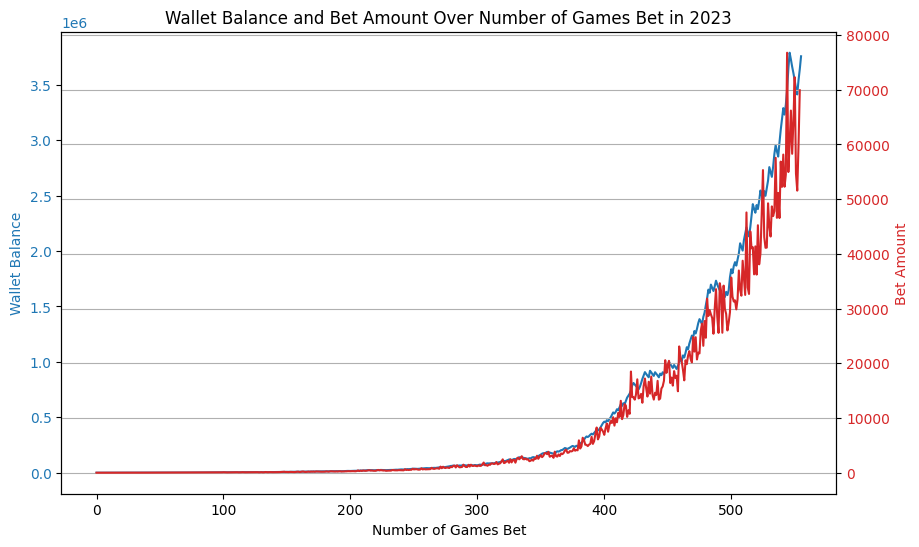

76766.08121600514
16.140821061795748
1000
3755331.2482357034


In [ ]:
test_year=season_start_year
plot_wallet_balance(better, test_year)
print(max(better.bet_history))
print(min(better.bet_history))
print(min(better.wallet_history))
print(better.wallet_history[-1])


In [ ]:
print(pd.DataFrame(better.detailed_bet_history[0:20]).transpose())

                               0                1                2   \
game_index        20230330SEACLE1  20230330SLNTOR1  20230330TBADET1   
bet_on_home_team             True            False             True   
amount_bet               17.32947        16.140821        20.658731   
outcome                       win              win              win   
wallet_after_bet      1042.803791      1069.758962      1120.786028   

                               3                4                5   \
game_index        20230330TEXPHI1  20230330WASATL1  20230331HOUCHA1   
bet_on_home_team             True            False             True   
amount_bet              22.821185        21.275064        21.402605   
outcome                       win              win              win   
wallet_after_bet      1177.154356      1212.683712      1265.548146   

                               6                7                8   \
game_index        20230331LANARI1  20230331MIANYN1  20230331SDNCOL1   
bet_

In [ ]:
print(ok)

[('20230330SEACLE1', 'True'), ('20230330SLNTOR1', 'False'), ('20230330TBADET1', 'True'), ('20230330TEXPHI1', 'True'), ('20230330WASATL1', 'False'), ('20230331HOUCHA1', 'True'), ('20230331LANARI1', 'True'), ('20230331MIANYN1', 'False'), ('20230331SDNCOL1', 'True'), ('20230331SEACLE1', 'True'), ('20230401BOSBAL1', 'False'), ('20230401CHNMIL1', 'True'), ('20230401CINPIT1', 'False'), ('20230401HOUCHA1', 'True'), ('20230401KCAMIN1', 'False'), ('20230401LANARI1', 'True'), ('20230401MIANYN1', 'False'), ('20230401NYASFN1', 'True'), ('20230401OAKANA1', 'False'), ('20230401SDNCOL1', 'True'), ('20230401SEACLE1', 'True'), ('20230401SLNTOR1', 'False'), ('20230401TBADET1', 'True'), ('20230401TEXPHI1', 'True'), ('20230401WASATL1', 'False'), ('20230402BOSBAL1', 'True'), ('20230402CHNMIL1', 'True'), ('20230402CINPIT1', 'False'), ('20230402HOUCHA1', 'True'), ('20230402KCAMIN1', 'False'), ('20230402LANARI1', 'True'), ('20230402MIANYN1', 'True'), ('20230402NYASFN1', 'True'), ('20230402OAKANA1', 'False'), 

In [ ]:
for i in per_game_finished['winner'][0:20]:
    print(per_game_finished['winner'])

Game_ID
20150405CHNSLN1    0
20150406ARISFN1    0
20150406CINPIT1    1
20150406DETMIN1    1
20150406HOUCLE1    1
                  ..
20230511CINNYN1    1
20230511KCACHA1    1
20230511MINSDN1    1
20230511NYATBA1    0
20230511OAKTEX1    0
Name: winner, Length: 18469, dtype: int32
Game_ID
20150405CHNSLN1    0
20150406ARISFN1    0
20150406CINPIT1    1
20150406DETMIN1    1
20150406HOUCLE1    1
                  ..
20230511CINNYN1    1
20230511KCACHA1    1
20230511MINSDN1    1
20230511NYATBA1    0
20230511OAKTEX1    0
Name: winner, Length: 18469, dtype: int32
Game_ID
20150405CHNSLN1    0
20150406ARISFN1    0
20150406CINPIT1    1
20150406DETMIN1    1
20150406HOUCLE1    1
                  ..
20230511CINNYN1    1
20230511KCACHA1    1
20230511MINSDN1    1
20230511NYATBA1    0
20230511OAKTEX1    0
Name: winner, Length: 18469, dtype: int32
Game_ID
20150405CHNSLN1    0
20150406ARISFN1    0
20150406CINPIT1    1
20150406DETMIN1    1
20150406HOUCLE1    1
                  ..
20230511CINNYN1    1
20

In [ ]:
for i  in better.bet_history[0:20]:
    print(i)

17.329469919204712
16.140821061795748
20.658731375788932
22.821185095506266
21.275063959344333
21.402604590616054
20.619415244980093
20.03673749343078
21.494991952198667
23.149956536528
19.17969051908281
19.654542462061755
21.05256405631851
22.19774028035945
22.61338726224265
21.79992511399631
19.254313684727343
22.6404269296243
23.166873025608577
23.916984965604037


In [ ]:
print(better2)

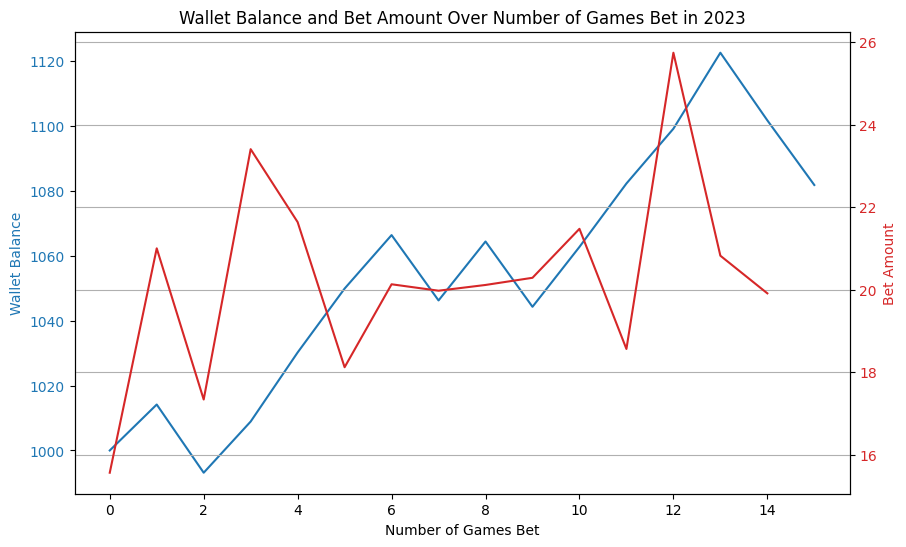

In [ ]:
plot_wallet_balance(better2, test_year)

In [ ]:
print(better2.bet_history)

[15.566763281822205, 21.006722099962616, 17.341797351837158, 23.41100852560359, 21.642746930656553, 18.124187969574677, 20.135435106908986, 19.9795256340392, 20.11888432631629, 20.292799077478644, 21.47974582987571, 18.56714764976656, 25.7493211929387, 20.8282952315745, 19.91593430344294]


In [ ]:
view_data(per_game_finished)

There are no NaN values in the dataset


In [ ]:
# view_data(pitcher_names)
view_data(batter_data)



    #return avg_class_report, avg_conf_matrix, better2.bet_history, better2.wallet_history, ok2


There are no NaN values in the dataset
